In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

## Make sure averaging region size is not larger than the box itself 

In [2]:
def check_averaging_radius_limit(averaging_radius, box_length):
    # check to see if averaging region is larger than the box itself
    if averaging_radius > (box_length-1)/2:
        raise ValueError(f'Averaging_radius = {averaging_radius} > \
{(box_length-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')## Measure the distance of each voxel to the center

## Measure the distance of each voxel to the center

In [3]:
@jit
def distance_from_coordinate(box_length):
    """
    Generate a cube of voxels.
    On each voxel, the distanace from the center is 
    calculated and the value is assigned to the voxel.
    jit by numba compiles what it can to machine code,
    the rest as python code.
    
    Parameters
    ----------
    box_length : int
        The length of each side of the cube.
        
    Returns
    -------
    distance : 3D-ndarray
        Cube of voxels with each voxel having its 
        distance from the center assigned to it.
    """
    # range of nummbers with 0 as the center    
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    # generating cube and computing distacne for each voxel
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [4]:
def random_cube_regions(box_length, number_of_coordinates, radius):
    """
    Selects a number cubical sub-regions
    within a larger cube at random positions.
    
    Parameters
    ----------
    box_length            : int
        Side length of the larger cube in
        arbitrary units of number of cells.
    number_of_coordinates : int
        Νumber of sub-regions to be selected.
    radius                : int
        Side of the smaller selected cubical 
        sub-region in arbitrary units of number of cells.
        Called radius because a sphere is
        often define within this smaller cube.
        
    Returns
    -------
    inds1 : ndarray dtype:int
        In 1D, the left bound that defines the cubical region.
    inds2 : ndarray dtype:int
        In 1D, the right bound that defines the cubical region.
    """
    
    np.random.seed()  # no entry: set seed to a randome number
#     np.random.seed(4)  # specifying seed for testing purposes

    # selecting 'number_of_coordiantes' random coordinates within larger cube
    coordinates = np.random.randint(0, box_length, size=(number_of_coordinates, 3))
    
    # cube indices 
    inds1 = (coordinates-radius).astype(int)
    inds2 = (coordinates+radius+1).astype(int)  # ending index is not inclusive
    

    return inds1, inds2

## Binary neutral spheres box

In [5]:
def binary_neutral_spheres_box(
    binary_box_length=300,
    neutral_sphere_radius=50,
    iterations=int(1e2)
):
    box=np.zeros((binary_box_length, binary_box_length, binary_box_length))
    
    # modified to return output_box_indices
    def modified_slicing_the_cube(ind1, ind2, box):
        """
        Selects a smaller cubical sub-region within a larger cube called 'box'.
        Incoorporates periodic boundary conditions, i.e. Pac-Man effect.
        This function takes in a set of slicing indices of one particular randomly
        selected cubical sub-region and returns the selected smaller cube.

        Parameters
        ----------
        ind1 : 1D ndarray, dtype: int
            The left bounds of the selected region in 1D respectively.
        ind2 : 1D ndarray, dtype: int
            The right bounds of the selected region in 1D respectively.
        box  : 3D ndarray, dtype: float32
            Data cube, when the smaller cubical
            sub-regions are being selected from.

        Returns
        -------
        output_box : 3D ndarray, dtype: float32
            The selected cubical smaller sub-region
            within the larger data cube.
        """

        if ind1[0] < 0:  # periodic boundary conditions
            # region that went beyond the zeroth voxel face of the
            # cube is replaced by the region at the 'len(box)gth'th
            # voxel face of the cube with the same size.
            x_inds = np.r_[(ind1[0]+len(box)):len(box), 0:ind2[0]]
        elif ind2[0] > len(box):
            # region that went beyond the 'len(box)gth'th voxel face
            # of the cube is replaced by the region at the zeroth 
            # voxel face of the cube with the same size.
            x_inds = np.r_[ind1[0]:len(box), 0:(ind2[0]-len(box))]
        else:
            # selected voxel is perfectly in the larger data cube.
            x_inds = np.r_[ind1[0]:ind2[0]]

        if ind1[1] < 0:
            y_inds = np.r_[(ind1[1]+len(box)):len(box), 0:ind2[1]]
        elif ind2[1] > len(box):
            y_inds = np.r_[ind1[1]:len(box), 0:(ind2[1]-len(box))]
        else:
            y_inds = np.r_[ind1[1]:ind2[1]]

        if ind1[2] < 0:
            z_inds = np.r_[(ind1[2]+len(box)):len(box), 0:ind2[2]]
        elif ind2[2] > len(box):
            z_inds = np.r_[ind1[2]:len(box), 0:(ind2[2]-len(box))]
        else:
            z_inds = np.r_[ind1[2]:ind2[2]]

        try:
            # box[indices]
            output_box_indices = np.ix_(x_inds, y_inds, z_inds)
            output_box = box[output_box_indices]

        except IndexError:  # sample region larger than box.
            print(f'ind1 = {ind1}')  # print useful info
            print(f'ind2 = {ind2}')  # for debugging
            print(f'box length = {len(box)}')
            print(f'x_ind1 = {ind1[0]}')
            print(f'x_ind2 = {ind2[0]}')
            print(f'x_inds = {x_inds}')
            print(f'y_ind1 = {ind1[1]}')
            print(f'y_ind2 = {ind2[1]}')
            print(f'y_inds = {y_inds}')
            print(f'z_ind1 = {ind1[2]}')
            print(f'z_ind2 = {ind2[2]}')
            print(f'z_inds = {z_inds}')

        return output_box_indices, output_box

    # modified to set the sphere to the average value
    def modified_top_hat_sphere_average(distance_box, neutral_sphere_radius, input_box):

        # really, this is the out_put box, using same
        # variable location to recycle the space in memory
        input_box = np.where(distance_box <= neutral_sphere_radius, 1, input_box)

        return input_box

    
    # check to see if averaging region is largert than the box itself
    check_averaging_radius_limit(neutral_sphere_radius, binary_box_length)

    # used as condition to define a sphere within a cube
    dist_frm_coord_box = distance_from_coordinate(neutral_sphere_radius*2+1)

    # iteration number of random cube region indices in the box
    rand_coord_inds1, rand_coord_inds2 = random_cube_regions(
        binary_box_length, 
        iterations, 
        neutral_sphere_radius
    )  


    
    for i in range(iterations):
        # selecting a cube centered about random coordinate, with sides 2*radius+1
        cube_region_box_indices, cube_region_box = modified_slicing_the_cube(
            rand_coord_inds1[i], 
            rand_coord_inds2[i], 
            box
        )
        
        # neutral sphere centered in a cube
        output_box = modified_top_hat_sphere_average(
            dist_frm_coord_box, 
            neutral_sphere_radius,
            cube_region_box
        )
        # assigning the cube to its place in the larger cube
        box[cube_region_box_indices] = output_box
    
    return box

## Neutral Sphere with Ionized Background Binary Boxes

In [6]:
iterations = np.array([1445, 180, 54, 22])
sphere_radii = np.array([10, 20, 30, 40])
binary_box_length=300


neutral_spheres_boxes = np.zeros((len(sphere_radii), binary_box_length, binary_box_length, binary_box_length))
overall_neutral_fractions = np.zeros(len(sphere_radii))

for i, radius in enumerate(sphere_radii):## Neutral Sphere with Ionized Background Binary Boxes
    neutral_spheres_boxes[i] = binary_neutral_spheres_box(
        binary_box_length=binary_box_length,
        neutral_sphere_radius=radius,
        iterations=iterations[i]
    )
    
    overall_neutral_fractions[i] = np.mean(neutral_spheres_boxes[i])

<ipython-input-3-4c4afb62d49a>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "distance_from_coordinate" failed type inference due to: Use of unsupported NumPy function 'numpy.meshgrid' or unsupported use of the function.

File "<ipython-input-3-4c4afb62d49a>", line 24:
def distance_from_coordinate(box_length):
    <source elided>
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    ^

During: typing of get attribute at <ipython-input-3-4c4afb62d49a> (24)

File "<ipython-input-3-4c4afb62d49a>", line 24:
def distance_from_coordinate(box_length):
    <source elided>
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    ^

  @jit
/lustre/aoc/projects/hera/wchin/anaconda3/envs/21cmfast/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "distance_from_coordinate" was compiled in object mode without forceobj=True.

Fi

## Colorbar function

In [7]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel(f'Neutral Fraction, $x_{{HI}}$', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
        
#     for spine in plt.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

In [8]:
np.shape(neutral_spheres_boxes)

(4, 300, 300, 300)

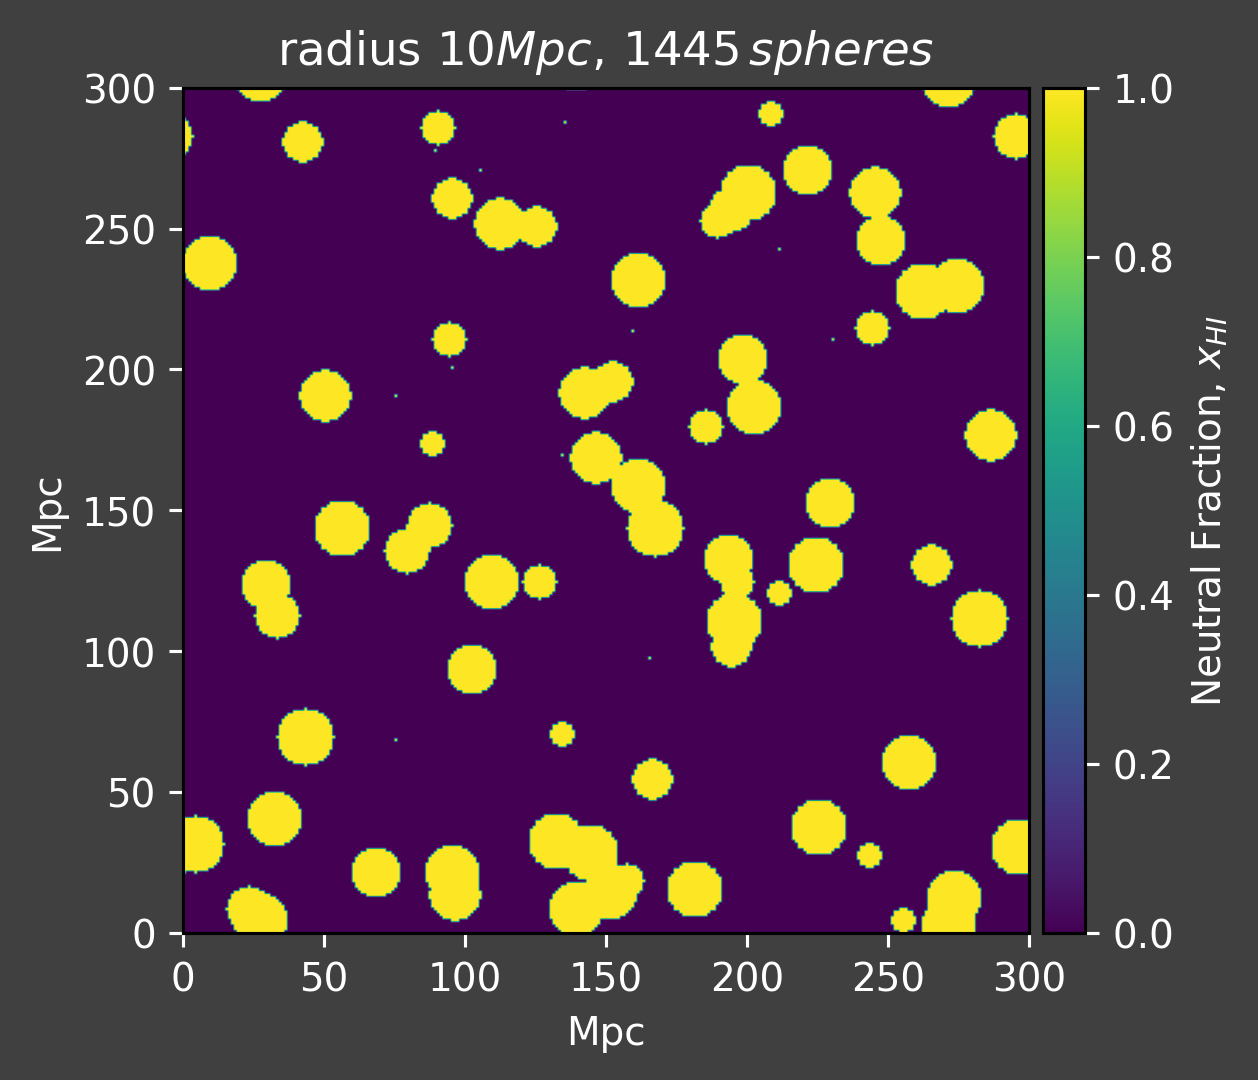

In [9]:
i=0

plt.figure(dpi=280, facecolor='#404040')
color='w'
im = plt.imshow(
    neutral_spheres_boxes[i][150, :, :], 
    extent=(0,np.shape(neutral_spheres_boxes[i])[1],0,np.shape(neutral_spheres_boxes[i])[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius ${sphere_radii[i]:d}Mpc, \, {iterations[i]:d} \, spheres$', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

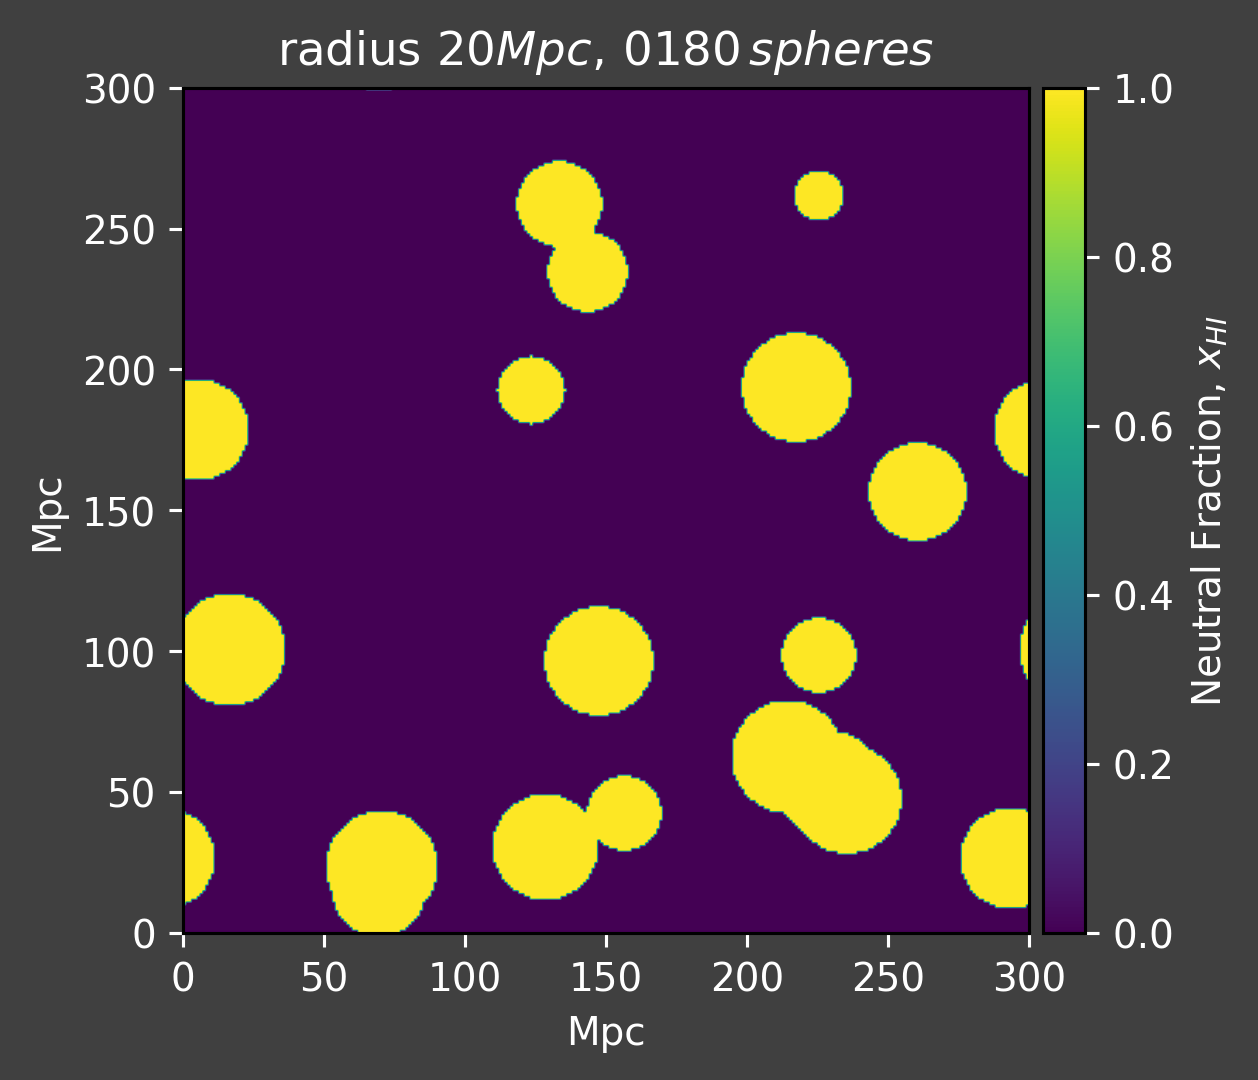

In [10]:
i=1

plt.figure(dpi=280, facecolor='#404040')
color='w'
im = plt.imshow(
    neutral_spheres_boxes[i][150, :, :], 
    extent=(0,np.shape(neutral_spheres_boxes[i])[1],0,np.shape(neutral_spheres_boxes[i])[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius ${sphere_radii[i]:d}Mpc, \, 0{iterations[i]:d} \, spheres$', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

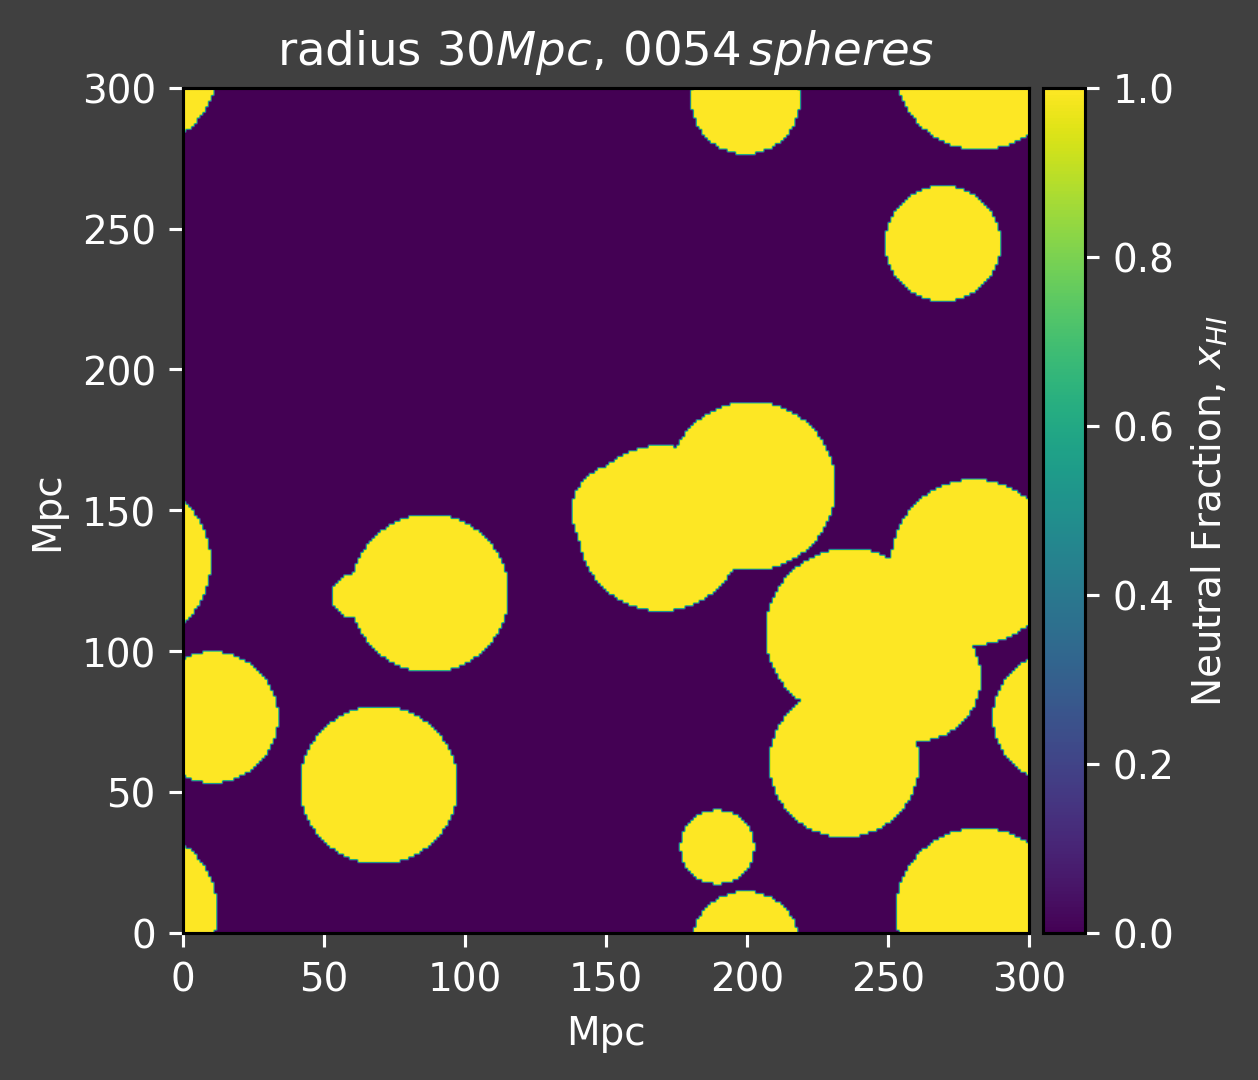

In [12]:
i=2

plt.figure(dpi=280, facecolor='#404040')
color='w'
im = plt.imshow(
    neutral_spheres_boxes[i][150, :, :], 
    extent=(0,np.shape(neutral_spheres_boxes[i])[1],0,np.shape(neutral_spheres_boxes[i])[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius ${sphere_radii[i]:d}Mpc, \, 00{iterations[i]:d} \, spheres$', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

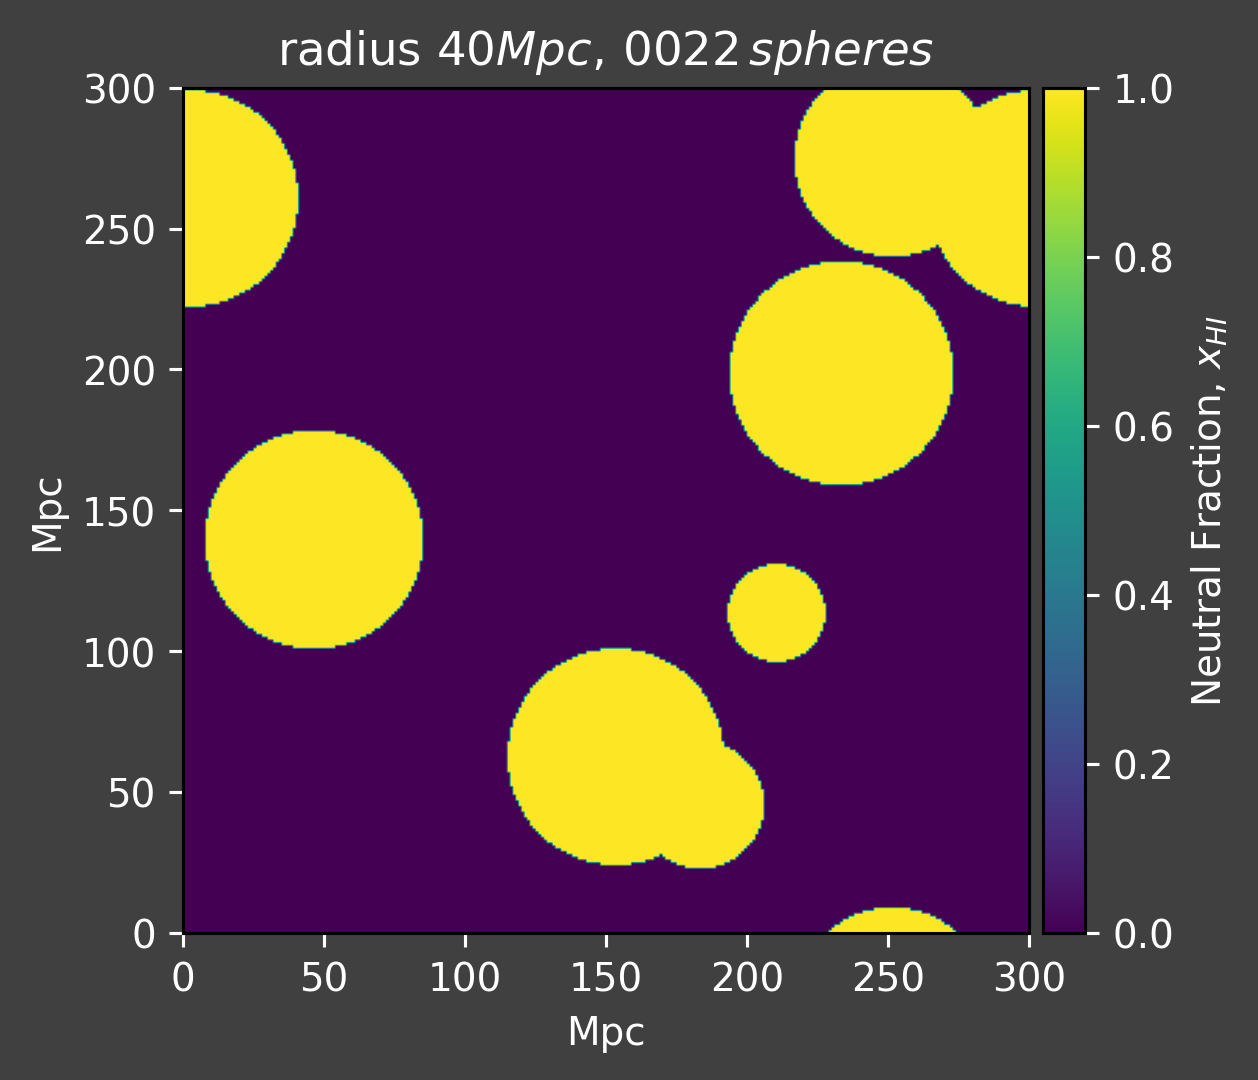

In [13]:
i=3

plt.figure(dpi=280, facecolor='#404040')
color='w'
im = plt.imshow(
    neutral_spheres_boxes[i][150, :, :], 
    extent=(0,np.shape(neutral_spheres_boxes[i])[1],0,np.shape(neutral_spheres_boxes[i])[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius ${sphere_radii[i]:d}Mpc, \, 00{iterations[i]:d} \, spheres$', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

## Slices plots function

In [13]:
def slices_plots(
    boxes,
    titles,
    color='w',
    figure_shape=[3, 3],
    figure_size=(18, 15),
    font_size=12,
    vertical_gap=0.1,
    horizontal_gap=0.1,
    shared_x_label='Mpc',
    shared_x_label_x_position=0.435,
    shared_x_label_y_position=0.08,
    shared_y_label='Mpc',
    shared_y_label_x_position=0.09,
    shared_y_label_y_postion=0.5,
    shared_title="Fred's Boxes",
    shared_title_x_position=0.5,
    shared_title_y_position=0.92,
    share_x_axis=True,
    share_y_axis=True,
    dpi=100
):

    fig, ax = plt.subplots(
        figure_shape[0], # row
        figure_shape[1], # column
        figsize=figure_size, 
        dpi=dpi,
        sharex=share_x_axis, 
        sharey=share_y_axis, 
        gridspec_kw={"hspace":vertical_gap, 'wspace': horizontal_gap}
    )
    for i, box in enumerate(boxes):
        im = ax.flatten()[i].imshow(
            box[150, :, :], 
            extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
            vmin=0, 
            vmax=1, 
            origin='lower'
        )
        ax.flatten()[i].set_title(
            titles[i], 
            color=color, 
            fontsize=font_size
        )
        ax.flatten()[i].tick_params(color=color, labelcolor=color, labelsize=font_size)

    fig.suptitle(
        x=shared_title_x_position, 
        y=shared_title_y_position, 
        t=shared_title, 
        ha='center', 
        size=1.5*font_size, 
        color=color
    )    

    if shared_x_label != None:  # shared x label
        fig.text(
            x=shared_x_label_x_position, 
            y=shared_x_label_y_position, 
            s=shared_x_label, 
            ha='center', 
            size=font_size, 
            color=color
        )

    if shared_y_label != None:  # shared y label
        fig.text(
            x=shared_y_label_x_position, 
            y=shared_y_label_y_postion, 
            s=shared_y_label, 
            va='center', 
            rotation='vertical', 
            size=font_size, 
            color=color
        )

    cbar = plt.colorbar(im, ax=ax.ravel().tolist())
    cbar.set_label("Neutral Fraction", color=color, size=font_size)
    cbytick_labels = plt.getp(cbar.ax.axes, 'yticklabels')                #tricky
    plt.setp(cbytick_labels, color=color, size=font_size)
    cbar.ax.yaxis.set_tick_params(color=color)

    plt.show()

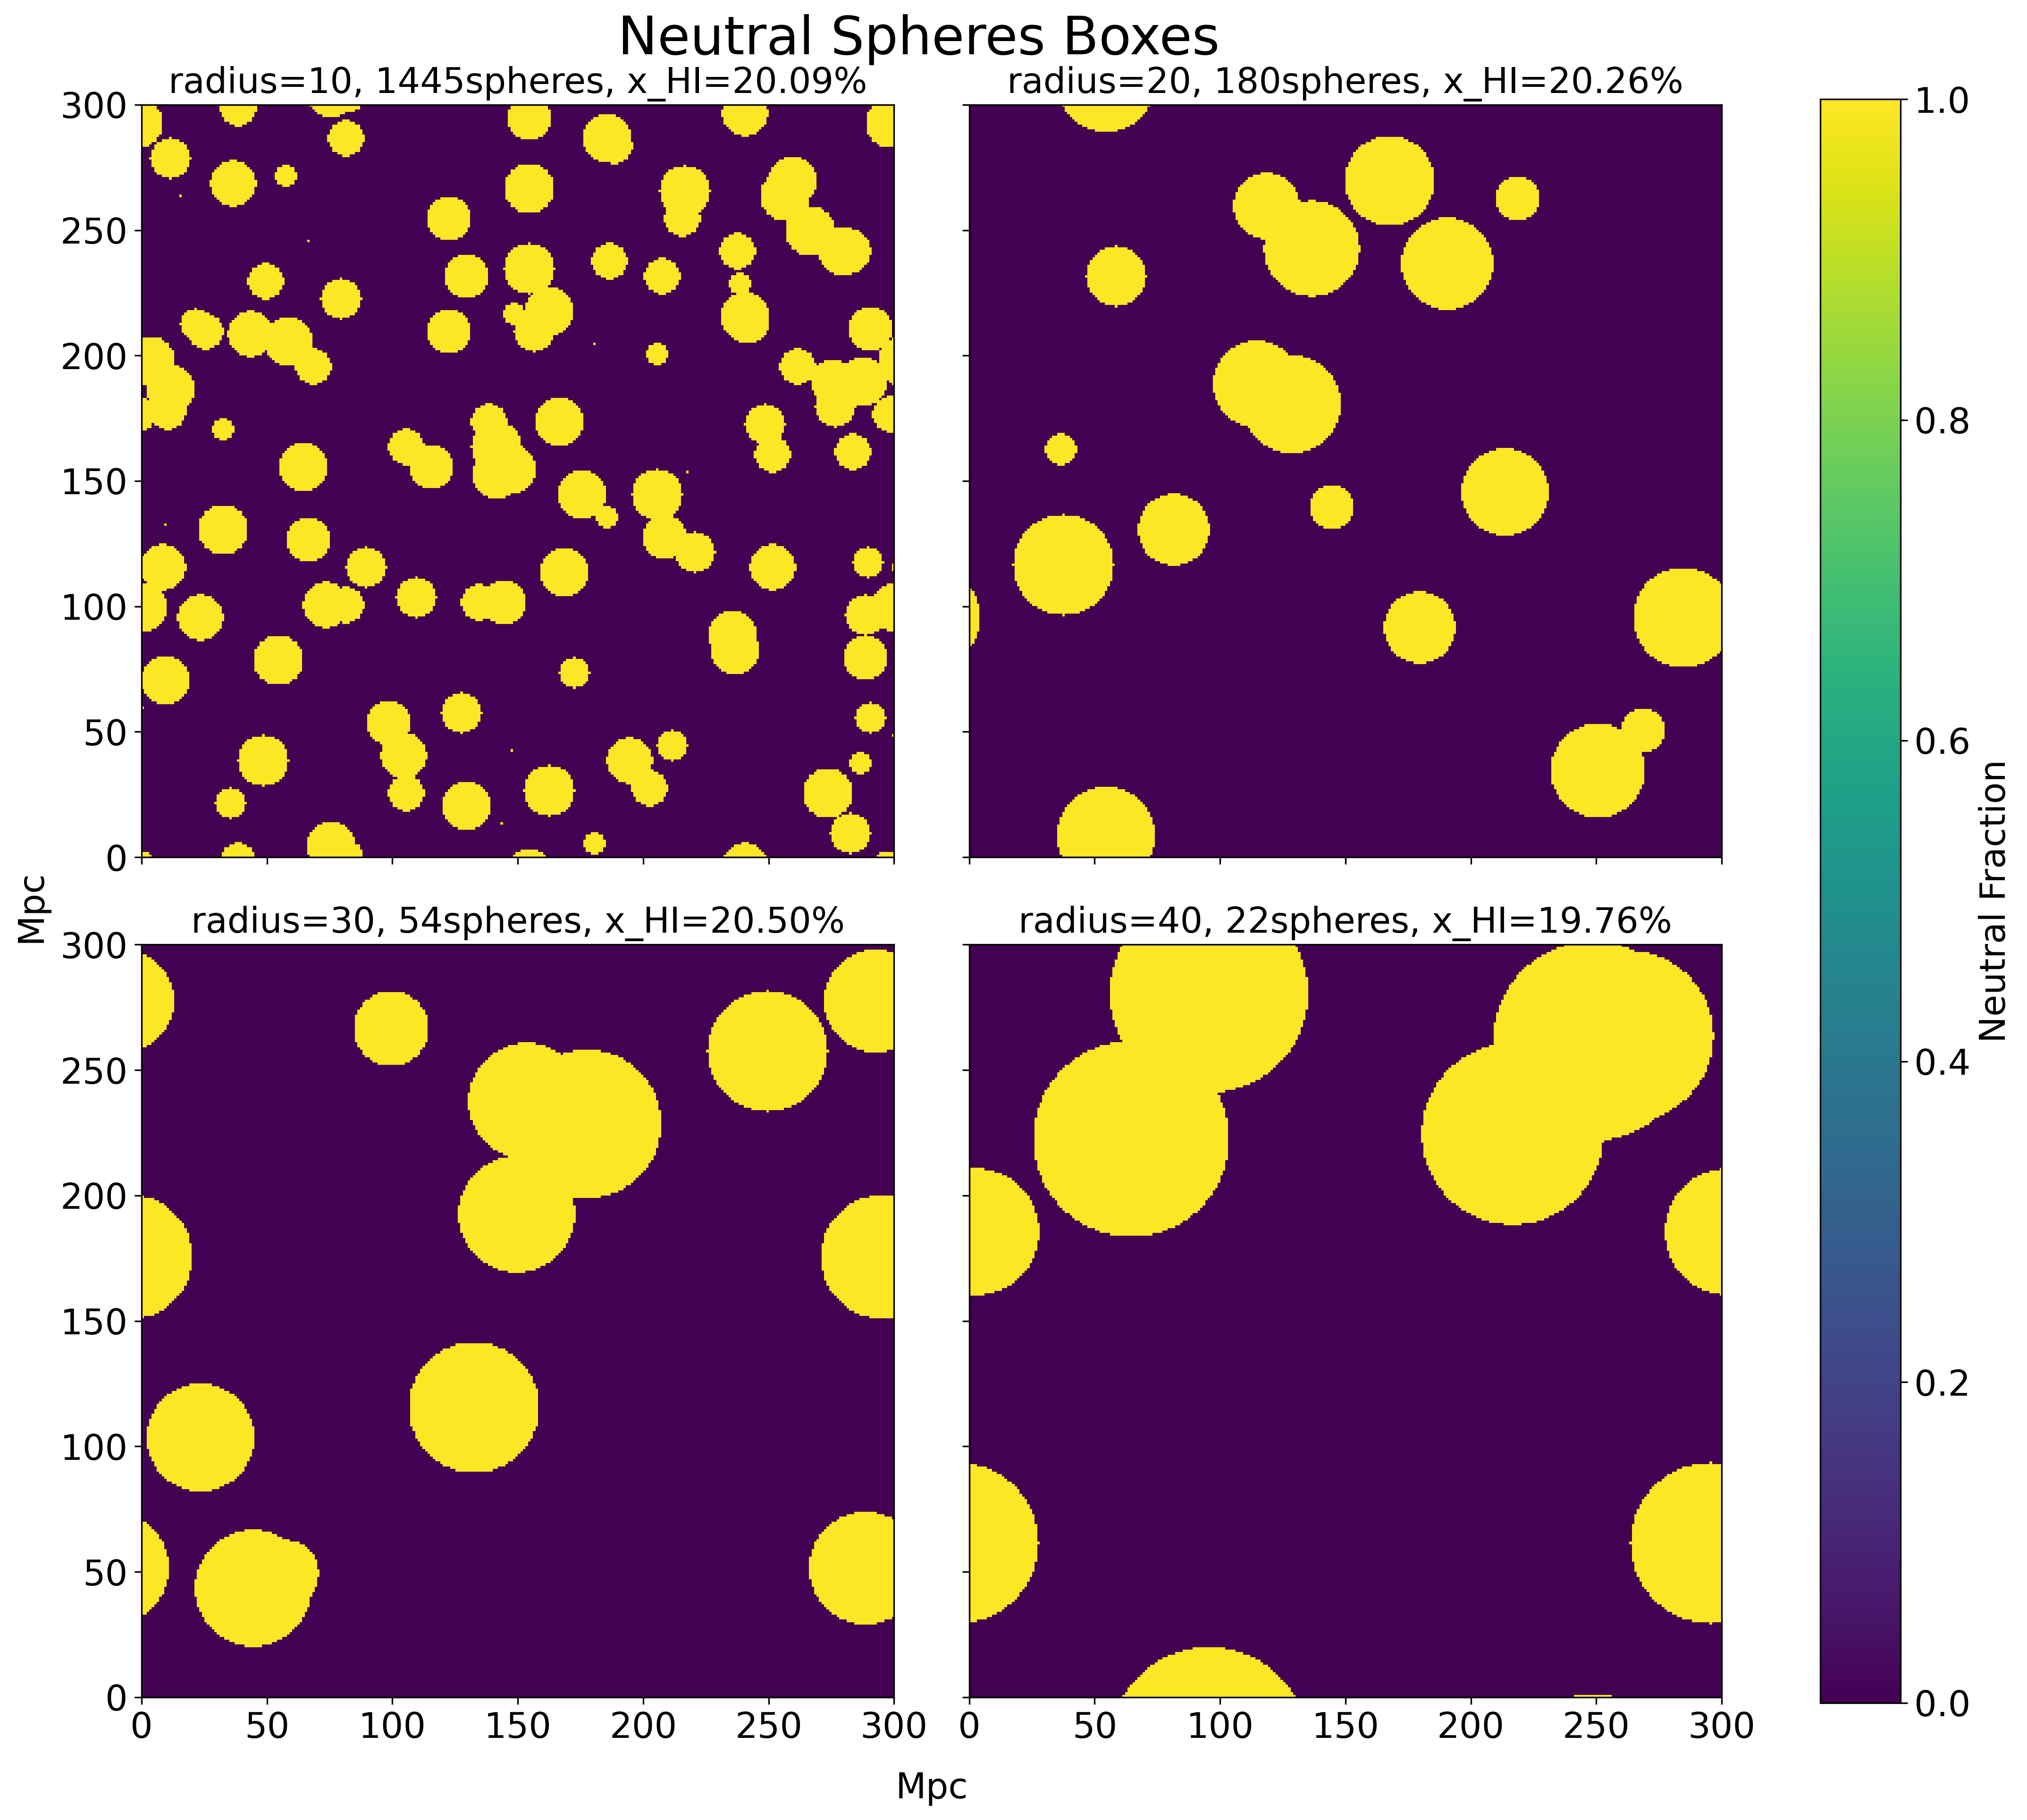

In [14]:
slices_plots(
    boxes=neutral_spheres_boxes,
    titles=[f'radius={radius:d}, \
{iterations[i]:d}spheres, \
x_HI={overall_neutral_fractions[i]*100:.2f}%\
' for i, radius in enumerate(sphere_radii)],
    color='k',
    figure_shape=[2, 2],
    figure_size=(18, 15),
    shared_title='Neutral Spheres Boxes',
    font_size=18,
    shared_title_x_position=0.43,
    shared_y_label_x_position=0.075,
    dpi=300
)